# Notebook 04 — India Macro Extension

This notebook extends the portfolio stress-testing framework by introducing
India-specific macroeconomic indicators.

Due to limited availability of long, high-frequency consumer credit data in
India, this extension focuses on macro stress dynamics and scenario calibration,
and compares them conceptually with the US macro framework developed earlier.

### Design Note

India does not provide an exact equivalent to FRED with long, consistent,
high-frequency macro series aligned to consumer credit portfolios.

As a result, this extension focuses on:
- Using authoritative public macro sources (RBI, MOSPI, World Bank)
- Aligning indicators conceptually with US macro drivers
- Demonstrating how stress scenarios can be transferred and adapted

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
INDIA_MACRO_SERIES = {
    "gdp_growth": "NY.GDP.MKTP.KD.ZG",     # Economic activity
    "inflation": "FP.CPI.TOTL.ZG",         # Inflation pressure
    "unemployment": "SL.UEM.TOTL.ZS",      # Labor stress
    "policy_rate": "INREPO",               # RBI repo rate (manual / CSV)
}

In [3]:
from pandas_datareader import wb

start_year = 2006
end_year = 2019

wb_data = wb.download(
    indicator=list(INDIA_MACRO_SERIES.values())[:3],
    country="IND",
    start=start_year,
    end=end_year
)

wb_data = wb_data.reset_index()
wb_data.head()

/var/folders/w8/m_kyvxdd6wb21r5j2p5qqw7r0000gn/T/ipykernel_71880/2670609568.py:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  wb_data = wb.download(


,country,year,NY.GDP.MKTP.KD.ZG,FP.CPI.TOTL.ZG,SL.UEM.TOTL.ZS
0,India,2006,8.060733,5.796523,7.552
1,India,2007,7.660815,6.372881,7.561
2,India,2008,3.086698,8.349267,7.656
3,India,2009,7.861889,10.882353,7.664
4,India,2010,8.497585,11.989390,7.652


In [4]:
india_macro = wb_data.rename(columns={
    "NY.GDP.MKTP.KD.ZG": "gdp_growth",
    "FP.CPI.TOTL.ZG": "inflation",
    "SL.UEM.TOTL.ZS": "unemployment"
})

india_macro = india_macro.sort_values("year")
india_macro.reset_index()
india_macro.head()

,country,year,gdp_growth,inflation,unemployment
0,India,2006,8.060733,5.796523,7.552
1,India,2007,7.660815,6.372881,7.561
2,India,2008,3.086698,8.349267,7.656
3,India,2009,7.861889,10.882353,7.664
4,India,2010,8.497585,11.989390,7.652


In [5]:
repo = pd.read_csv("data/rbi_repo_rate.csv")

repo = repo[["Unnamed: 1", "Unnamed: 2"]].copy()
repo.columns = ["date", "repo_rate"]

repo = repo[repo["date"] != "Date"]

repo["date"] = (
    repo["date"]
    .str.replace("–", "-", regex=False)
    .str.strip()
)

repo["date"] = pd.to_datetime(
    repo["date"],
    dayfirst=True,
    errors="coerce"
)

repo["repo_rate"] = (
    repo["repo_rate"]
    .str.replace("%", "", regex=False)
    .astype(float)
)

repo.head()

,date,repo_rate
1,2025-12-05,5.25
2,2025-10-01,5.50
3,2025-06-06,5.50
4,2025-04-09,6.00
5,2025-02-07,6.25


In [6]:
repo = repo.sort_values("date")

repo_core = repo[
    (repo["date"] >= "2006-01-01") &
    (repo["date"] <= "2018-12-31")
].copy()

In [7]:
repo_core["year"] = repo_core["date"].dt.year

repo_annual = (
    repo_core
    .groupby("year")["repo_rate"]
    .mean()
    .reset_index()
)

repo_annual.head()

,year,repo_rate
0,2006,6.825000
1,2007,7.650000
2,2008,7.916667
3,2009,5.100000
4,2010,5.650000


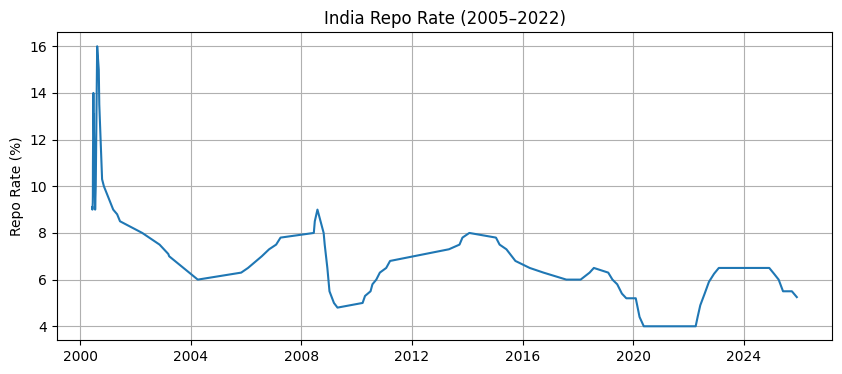

In [8]:
plt.figure(figsize=(10,4))
plt.plot(repo["date"], repo["repo_rate"])
plt.title("India Repo Rate (2005–2022)")
plt.ylabel("Repo Rate (%)")
plt.grid(True)
plt.show()

The extended window provides macroeconomic context and regime comparison, but stress calibration and loss propagation are restricted to the portfolio-aligned period to avoid look-ahead bias.

### Time Window Alignment

India repo rate data is available through 2022. For stress calibration and
portfolio alignment, the analysis window is restricted to 2006–2018, consistent
with the loan issuance period. Post-2018 observations are retained only for
contextual visualization and regime comparison.

In [9]:
india_macro

,country,year,gdp_growth,inflation,unemployment
0,India,2006,8.060733,5.796523,7.552
1,India,2007,7.660815,6.372881,7.561
2,India,2008,3.086698,8.349267,7.656
3,India,2009,7.861889,10.882353,7.664
4,India,2010,8.497585,11.989390,7.652
5,India,2011,5.241316,8.911793,7.616
6,India,2012,5.456388,9.478997,7.666
7,India,2013,6.386106,10.017878,7.711
8,India,2014,7.410228,6.665657,7.674
9,India,2015,7.996254,4.906973,7.631


In [10]:
india_macro["year"] = india_macro["year"].astype(int)
repo_annual["year"] = repo_annual["year"].astype(int)

In [11]:
india_macro = india_macro.merge(
    repo_annual,
    on="year",
    how="left"
)

In [12]:
india_macro["repo_rate"] = india_macro["repo_rate"].ffill()

In [13]:
india_macro.head()


,country,year,gdp_growth,inflation,unemployment,repo_rate
0,India,2006,8.060733,5.796523,7.552,6.825000
1,India,2007,7.660815,6.372881,7.561,7.650000
2,India,2008,3.086698,8.349267,7.656,7.916667
3,India,2009,7.861889,10.882353,7.664,5.100000
4,India,2010,8.497585,11.989390,7.652,5.650000


In [14]:
india_macro.describe()

,year,gdp_growth,inflation,unemployment,repo_rate
count,14.0000,14.000000,14.000000,14.000000,14.000000
mean,2012.5000,6.645356,7.094031,7.554571,6.732738
std,4.1833,1.682953,2.837450,0.303742,0.868836
min,2006.0000,3.086698,3.328173,6.510000,5.100000
25%,2009.2500,5.688817,4.917284,7.604750,6.266667
50%,2012.5000,7.102806,6.519269,7.641500,6.650000
75%,2015.7500,7.962663,9.337196,7.662000,7.487500
max,2019.0000,8.497585,11.989390,7.711000,8.000000


In [15]:
macro_cols = [
    "gdp_growth",
    "inflation",
    "unemployment",
    "repo_rate"
]

baseline = india_macro[macro_cols].mean()
baseline

gdp_growth      6.645356
inflation       7.094031
unemployment    7.554571
repo_rate       6.732738
dtype: float64

In [16]:
india_scenarios = pd.DataFrame({
    "scenario": ["baseline", "adverse", "severe"],

    "gdp_growth": [
        baseline["gdp_growth"],
        baseline["gdp_growth"] - 2,
        baseline["gdp_growth"] - 4
    ],

    "inflation": [
        baseline["inflation"],
        baseline["inflation"] + 2,
        baseline["inflation"] + 4
    ],

    "unemployment_rate": [
        baseline["unemployment"],
        baseline["unemployment"] + 1,
        baseline["unemployment"] + 2
    ],

    "repo_rate": [
        baseline["repo_rate"],
        baseline["repo_rate"] + 1.5,
        baseline["repo_rate"] + 3.0
    ]
})

india_scenarios

,scenario,gdp_growth,inflation,unemployment_rate,repo_rate
0,baseline,6.645356,7.094031,7.554571,6.732738
1,adverse,4.645356,9.094031,8.554571,8.232738
2,severe,2.645356,11.094031,9.554571,9.732738


In [21]:
india_shocks = india_scenarios.set_index("scenario")
india_shocks = india_shocks / india_shocks.loc["baseline"]

india_shocks

,gdp_growth,inflation,unemployment_rate,repo_rate
scenario,,,,
baseline,1.000000,1.000000,1.00000,1.000000
adverse,0.699038,1.281927,1.13237,1.222792
severe,0.398076,1.563854,1.26474,1.445584


In [22]:
india_shocks.to_csv("data/processed/india_macro_scenarios_shocks.csv")

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

us_shocks = pd.read_csv(
    "data/processed/macro_scenarios_shocks.csv",
    index_col=0
)

india_shocks = pd.read_csv(
    "data/processed/india_macro_scenarios_shocks.csv",
    index_col=0
)

In [25]:
shock_compare = pd.DataFrame({
    "US_avg_shock": us_shocks.mean(axis=1),
    "India_avg_shock": india_shocks.mean(axis=1)
})

shock_compare

,US_avg_shock,India_avg_shock
scenario,,
baseline,1.000000,1.000000
adverse,1.225519,1.084032
severe,1.449037,1.168064


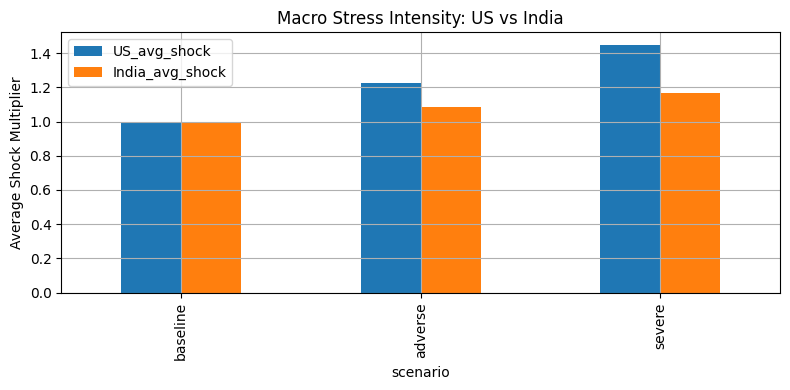

In [26]:
shock_compare.plot(
    kind="bar",
    figsize=(8, 4),
    title="Macro Stress Intensity: US vs India"
)
plt.ylabel("Average Shock Multiplier")
plt.grid(True)
plt.tight_layout()
plt.show()

## Interpreting India Macro Stress

India macro stress differs structurally from the US. While US stress scenarios
are heavily influenced by labor market shocks, India stress transmission is
more strongly driven by inflation persistence and monetary policy tightening.

As a result, RBI policy rates act as a compact but powerful proxy for broader
credit conditions, amplifying real-economy stress during adverse scenarios.

## Key Takeaways

- World Bank indicators capture structural economic stress in India
- RBI repo rates represent the policy transmission channel
- Combining both enables realistic stress testing under data constraints
- The framework adapts cleanly across geographies without requiring identical data

This extension demonstrates the portability of portfolio stress-testing
frameworks to emerging markets.